# Treść zadania

Wytrenować sieć GAN do generowania obrazów  w oparciu o 300 obrazów Moneta.

Dane są dostępne:

https://github.com/mmazurek-wat/nlp-resources-edu/blob/766a96b891da7b0d4c00b56df2085fd673c4c451/monet_jpg.zip

In [ ]:
!pip install -q torchinfo

In [ ]:
import random
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from pydantic import BaseModel
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm import tqdm

In [ ]:
# Constants & Defaults
DATA_URL = (
    "https://github.com/mmazurek-wat/nlp-resources-edu/blob/"
    "766a96b891da7b0d4c00b56df2085fd673c4c451/monet_jpg.zip?raw=true"
)
DEFAULT_DATA_ROOT = "data"
OUT_DIR = "outputs"
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Dataset utilities

In [ ]:
def download_file(url: str, dest: Path, chunk_size: int = 8192) -> None:
    with requests.get(url, stream=True, timeout=60) as r:
        r.raise_for_status()
        total = int(r.headers.get("Content-Length", 0))
        with (
            tqdm(total=total, unit="B", unit_scale=True, desc=dest.name) as pbar,
            dest.open("wb") as f,
        ):
            for chunk in r.iter_content(chunk_size):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))

In [ ]:
def safe_extract(zip_path: Path, out_dir: Path) -> None:
    with zipfile.ZipFile(zip_path) as zf:
        for member in zf.infolist():
            member_path = out_dir / member.filename
            if not str(member_path.resolve()).startswith(str(out_dir.resolve())):
                raise RuntimeError("Unsafe path detected in zip file")
        zf.extractall(out_dir)

In [ ]:
def prepare_dataset(root: Path | str = DEFAULT_DATA_ROOT, url: str = DATA_URL) -> Path:
    root = Path(root)
    img_dir = root / "monet_jpg"
    if img_dir.is_dir() and any(img_dir.iterdir()):
        return img_dir  # Already prepared

    root.mkdir(parents=True, exist_ok=True)
    tmp_zip = root / "tmp_download.zip"
    print(f"Downloading dataset to {tmp_zip} …")
    download_file(url, tmp_zip)

    print("Extracting …")
    safe_extract(tmp_zip, img_dir)
    tmp_zip.unlink(missing_ok=True)

    return img_dir

In [ ]:
def plot_images(images, nrow=8, padding=2, normalize=True, title=None):
    """Plot a grid of images."""
    grid = vutils.make_grid(images, nrow=nrow, padding=padding, normalize=normalize)
    plt.figure(figsize=(nrow * 2, nrow * 2))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

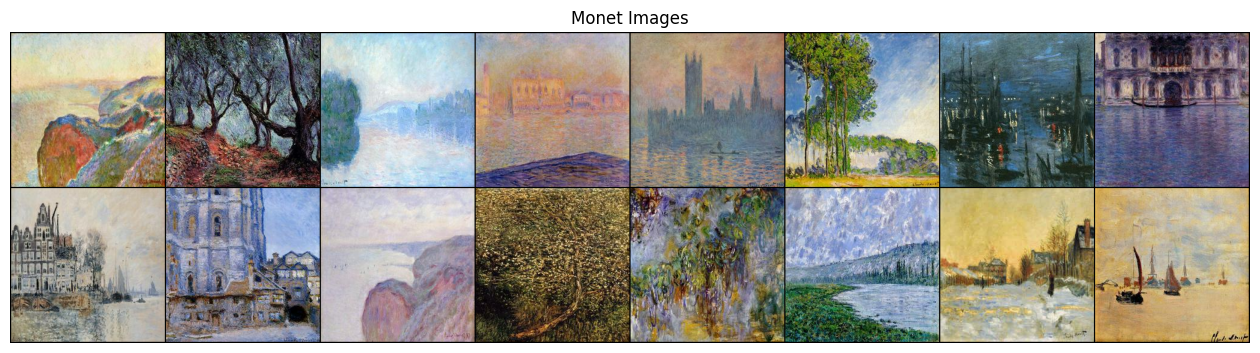

In [ ]:
data_dir = prepare_dataset(DEFAULT_DATA_ROOT)
images = datasets.ImageFolder(
    root=str(data_dir.parent), transform=transforms.ToTensor()
)
samples = []
for i in range(len(images)):
    sample, _ = images[i]
    samples.append(sample)
    if len(samples) == 16:
        break
plot_images(samples, nrow=8, padding=2, normalize=True, title="Monet Images")

## Model definitions (DCGAN)

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz: int = 100, ngf: int = 64, nc: int = 3):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.main(z)

In [ ]:
generator = Generator()
summary(generator, verbose=0)

Layer (type:depth-idx)                   Param #
Generator                                --
├─Sequential: 1-1                        --
│    └─ConvTranspose2d: 2-1              819,200
│    └─BatchNorm2d: 2-2                  1,024
│    └─ReLU: 2-3                         --
│    └─ConvTranspose2d: 2-4              2,097,152
│    └─BatchNorm2d: 2-5                  512
│    └─ReLU: 2-6                         --
│    └─ConvTranspose2d: 2-7              524,288
│    └─BatchNorm2d: 2-8                  256
│    └─ReLU: 2-9                         --
│    └─ConvTranspose2d: 2-10             131,072
│    └─BatchNorm2d: 2-11                 128
│    └─ReLU: 2-12                        --
│    └─ConvTranspose2d: 2-13             3,072
│    └─Tanh: 2-14                        --
Total params: 3,576,704
Trainable params: 3,576,704
Non-trainable params: 0

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, nc: int = 3, ndf: int = 64):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        return self.main(img).view(-1, 1).squeeze(1)

In [ ]:
discriminator = Discriminator()
summary(discriminator, verbose=0)

Layer (type:depth-idx)                   Param #
Discriminator                            --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       3,072
│    └─LeakyReLU: 2-2                    --
│    └─Conv2d: 2-3                       131,072
│    └─BatchNorm2d: 2-4                  256
│    └─LeakyReLU: 2-5                    --
│    └─Conv2d: 2-6                       524,288
│    └─BatchNorm2d: 2-7                  512
│    └─LeakyReLU: 2-8                    --
│    └─Conv2d: 2-9                       2,097,152
│    └─BatchNorm2d: 2-10                 1,024
│    └─LeakyReLU: 2-11                   --
│    └─Conv2d: 2-12                      8,192
│    └─Sigmoid: 2-13                     --
Total params: 2,765,568
Trainable params: 2,765,568
Non-trainable params: 0

## Training utilities

In [ ]:
def init_weights(m: nn.Module) -> None:
    """Initialize model weights (DCGAN paper)."""
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def set_seed(seed: int = SEED) -> None:
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def train(
    data_root: Path,
    out_dir: Path,
    epochs: int = 50,
    batch_size: int = 128,
    lr: float = 2e-4,
    beta1: float = 0.5,
    nz: int = 100,
    save_evey_n_epochs: int = 5,
    device: str = "cpu",
) -> None:
    out_dir = Path(out_dir)
    runs = list(out_dir.glob("run_*"))
    if runs:
        last_run = max(runs, key=lambda x: int(x.name.split("_")[-1]))
        next_run = f"run_{int(last_run.name.split('_')[-1]) + 1}"
    else:
        next_run = "run_0"
    out_dir = out_dir / next_run
    out_dir.mkdir(parents=True, exist_ok=True)

    # Dataset & Loader
    transform = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.ToTensor(),
            transforms.Normalize([0.5] * 3, [0.5] * 3),
        ]
    )
    dataset = datasets.ImageFolder(root=str(data_root.parent), transform=transform)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=torch.cuda.is_available(),
    )

    # Models
    netG = Generator(nz=nz).to(device)
    netD = Discriminator().to(device)
    netG.apply(init_weights)
    netD.apply(init_weights)

    # Loss & Optimizers
    criterion = nn.BCELoss()
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    real_label = 1.0
    fake_label = 0.0

    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    # Training Loop
    for epoch in range(epochs):
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for i, (imgs, _) in enumerate(pbar):
            b_size = imgs.size(0)
            imgs = imgs.to(device)

            # --------------------------------------------------
            # (1) Update Discriminator: log(D(x)) + log(1 − D(G(z)))
            # --------------------------------------------------
            netD.zero_grad()
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            output = netD(imgs)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            # --------------------------------------------------
            # (2) Update Generator: log(D(G(z)))
            # --------------------------------------------------
            netG.zero_grad()
            label.fill_(real_label)  # Generator tries to fool the discriminator
            output = netD(fake)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            pbar.set_postfix(
                {
                    "Loss_D": f"{errD.item():.4f}",
                    "Loss_G": f"{errG.item():.4f}",
                    "D(x)": f"{D_x:.3f}",
                    "D(G(z))": f"{D_G_z1:.3f}/{D_G_z2:.3f}",
                }
            )

        # Save sample grid each epoch
        if (epoch + 1) % save_evey_n_epochs == 0:
            with torch.inference_mode():
                fake_fixed = netG(fixed_noise).detach().cpu()
            grid = vutils.make_grid(fake_fixed, padding=2, normalize=True)
            vutils.save_image(grid, out_dir / f"epoch_{epoch+1:03d}.png")

    # Final model save
    torch.save(
        {
            "generator_state_dict": netG.state_dict(),
            "discriminator_state_dict": netD.state_dict(),
            "nz": nz,
        },
        out_dir / "dcgan_monet.pth",
    )
    print(f"Training finished. Results saved to {out_dir}.")

In [ ]:
class HParams(BaseModel):
    epochs: int = 1000
    batch_size: int = 128
    lr: float = 2e-4
    beta1: float = 0.5
    nz: int = 500

## Training

In [ ]:
set_seed(SEED)
data_dir = prepare_dataset(DEFAULT_DATA_ROOT)
hparams = HParams()
train(
    data_root=data_dir,
    epochs=hparams.epochs,
    batch_size=hparams.batch_size,
    lr=hparams.lr,
    beta1=hparams.beta1,
    nz=hparams.nz,
    device=DEVICE,
    out_dir=OUT_DIR,
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1000/1000: 100%|██████████| 3/3 [00:01<00:00,  2.65it/s, Loss_D=1.4380, Loss_G=2.0580, D(x)=0.582, D(G(z))=0.540/0.192]


Training finished. Results saved to outputs/run_1.


In [ ]:
# Load model
runs = list(Path(OUT_DIR).glob("run_*"))
last_run = max(runs, key=lambda x: int(x.name.split("_")[-1]))
checkpoint = torch.load(last_run / "dcgan_monet.pth")
netG = Generator(nz=checkpoint["nz"]).to(DEVICE)
netG.load_state_dict(checkpoint["generator_state_dict"])

<All keys matched successfully>

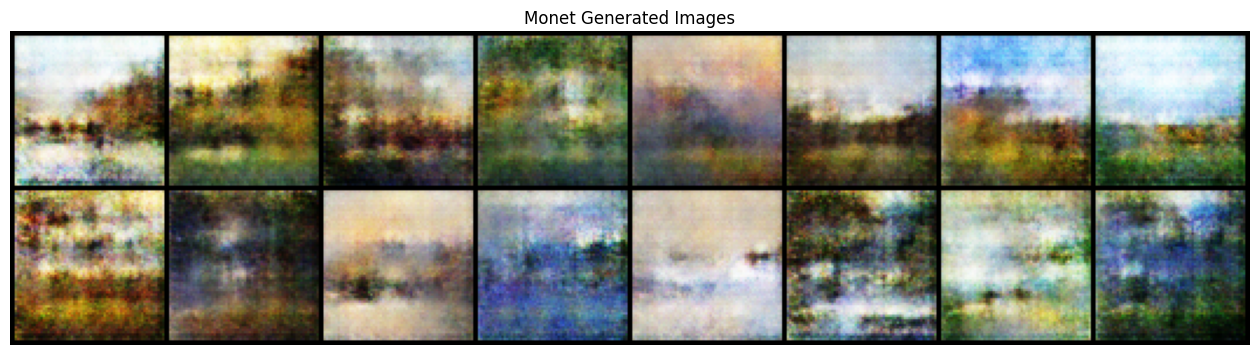

In [ ]:
# Generate
fixed_noise = torch.randn(16, checkpoint["nz"], 1, 1, device=DEVICE)
with torch.inference_mode():
    generate_samples = netG(fixed_noise).detach().cpu()
plot_images(
    generate_samples, nrow=8, padding=2, normalize=True, title="Monet Generated Images"
)